# Amazon Review Analysis

In this project, I will be exploring a dataset consisting of 100,000 Amazon.com review texts as well as the respective star ratings. Most of the notebook contains data manipulation, vizualization and unsupervised analysis of the reviews, while the final section deals with constructing a bag of words model for star rating classification. 

This was done as a class project for CIS 545 Big Data Analytics, and the final model achieved the highest score among all the class projects, including the model constructed by the TAs.

## Loading Packages/Data

In [ ]:
!pip install -U gensim
!pip install pyldavis
!pip install squarify
!pip install urllib2

In [ ]:
import gensim
import numpy as np
import pandas as pd
import squarify
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from pprint import pprint

from gensim import corpora
from gensim import matutils
from gensim.models import LsiModel, KeyedVectors, LdaModel
from gensim.models.tfidfmodel import TfidfModel
from gensim.models.nmf import Nmf
from gensim.models import HdpModel

import pyLDAvis
import pyLDAvis.gensim 

import sklearn.model_selection as ms
from sklearn.model_selection import cross_val_score
import sklearn.metrics as metrics
from sklearn import linear_model
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn import naive_bayes

from datetime import *
from operator import itemgetter

import random

/usr/local/lib/python3.6/dist-packages/_pytest/mark/structures.py:426: DeprecationWarning: The usage of `cmp` is deprecated and will be removed on or after 2021-06-01.  Please use `eq` and `order` instead.
  @attr.s(cmp=False, hash=False)


In [ ]:
!wget https://cis.upenn.edu/~cis545/data/reviews.dict
!wget https://cis.upenn.edu/~cis545/data/train_reviews.mm
!wget https://cis.upenn.edu/~cis545/data/train_times.npy

In [ ]:
reviews_dict = corpora.Dictionary.load("reviews.dict")
reviews_bow = corpora.MmCorpus('train_reviews.mm')
reviews_times  = np.load('train_times.npy')
reviews_times.shape = (len(reviews_bow),1)
y = np.vstack((np.repeat(1, 4000), np.repeat(2, 4000), np.repeat(3, 4000), np.repeat(4, 4000), np.repeat(5, 4000)))
y = np.repeat(y, 5)

## Investigating Time Data


In this section we are going to investigate possible relationships between time and the review score, not only looking for correlation but searching for interesting patters in the data.

### Getting Data in The Right Format

Currently the time data is represented in seconds, and while that helps with making relative comparisons between two times it makes it very hard to interpret patterns with time. The function below takes in the list of review times (in seconds) and returns a list of datetime objects, which as we will see later in this section section have useful characteristics that will aid our analysis

In [ ]:
def convert_times(reviews_times):
  x = []
  for i in reviews_times:
    x.append(datetime.fromtimestamp(i))
  x = pd.Series(x)
  return x

The datetime objects have a datetime.month attribute that will give us the numerical value of the month of that object, however being able to view the name of the month will make interpreting our results easier, so we also create a function that converts the month from number to text

In [ ]:
def convert_to_text(number):
  num_to_month = {1:"Jan",
                  2:"Feb",
                  3:"Mar",
                  4:"Apr",
                  5:"May",
                  6:"Jun",
                  7:"Jul",
                  8:"Aug",
                  9:"Sep",
                  10:"Oct",
                  11:"Nov",
                  12:"Dec"}
  
  return num_to_month[number]

Now time for some analysis. I am going to import the data into a DataFrame, so that I can extract characteristics of each datetime object into separate columns.

In [ ]:
# convert the times using the previous funciton
conv_times = convert_times(reviews_times)
# import the time data into a df, and name the column suitably
times = pd.DataFrame(conv_times)
times.columns = ['Date']
# extract three different features of each timestamp into a seperate column, the year, month, and day of the month
times['Year'] = times.Date.apply(lambda x: x.year)
times['Month'] = times.Date.apply(lambda x: x.month)
times['Day'] = times.Date.apply(lambda x: str(x.day))
# also add a column pertaining to the scores of the review at those times
times['Score'] = pd.Series(y)

# create a new DataFrame with the mean review score for each day of the year
times_year = times.groupby(['Month', 'Day']).mean().reset_index()[['Month', 'Day', 'Score']]
# convert the month column from numbers to text
times_year['Month'] = times_year['Month'].apply(lambda x: convert_to_text(x))
# create a date column by concatenating the month and day column values
times_year['Date'] = times_year['Month'].str.cat(times_year['Day'], sep = " ")
# create a column that keeps track of number of reviews
times_year['Count'] = times.groupby(['Month', 'Day']).count().reset_index()['Score']

# create a new DataFrame with the mean review score and review count for every day across the whole timeframe of the dataset
times_date = times.groupby(['Date']).mean().reset_index()[['Score', 'Date']]
times_date['Count'] = times.groupby(['Date']).count().reset_index()['Score']



### Plotting and Observing Relationships

Using the first DataFrame we created let us see if there are any correlation between the day of the year that the review was posted and the star rating of the review

Text(0, 0.5, 'Average Star Rating')

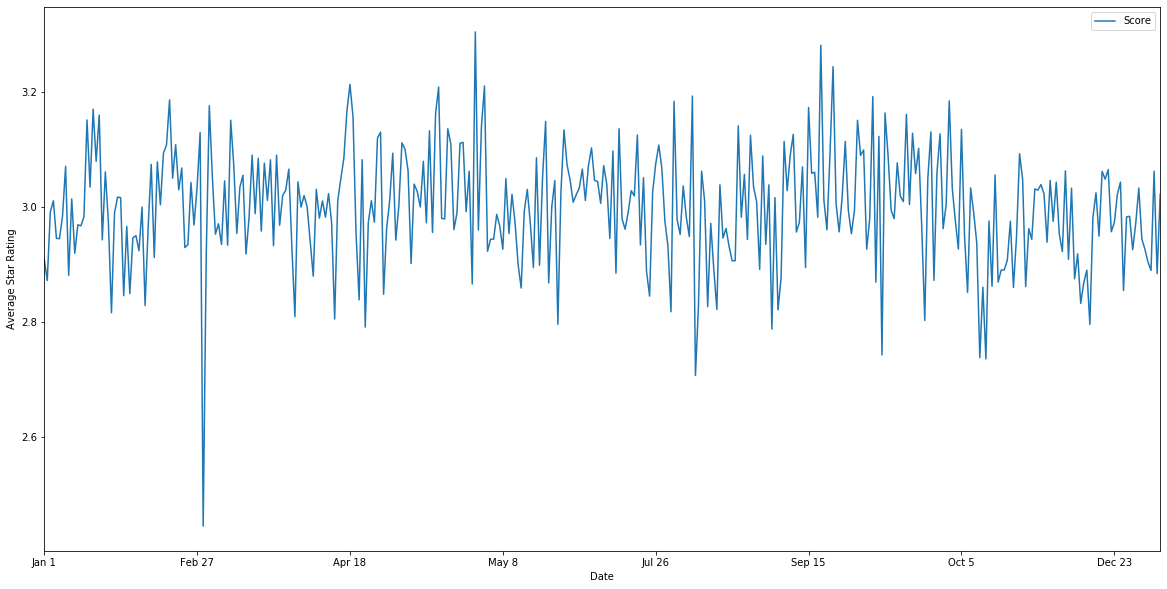

In [ ]:
ax = times_year.plot('Date', 'Score', figsize = (20,10))
ax.set_ylabel("Average Star Rating")

It seems that while the average score tends to fluctuate around 3.0 for most of the year there is one day, just after Feb 27, where it drops by over 15%! (Looks like some people might not have been happy with their valentines gifts!)

Valentine's aside, it is likely that this is an outlier, possibly a day where there weren't many reviews and so the average score is skewed. Let's have a look at the same timeline but this time the number of reviews on each day rather than the average star rating.

Text(0, 0.5, 'Number of Reviews')

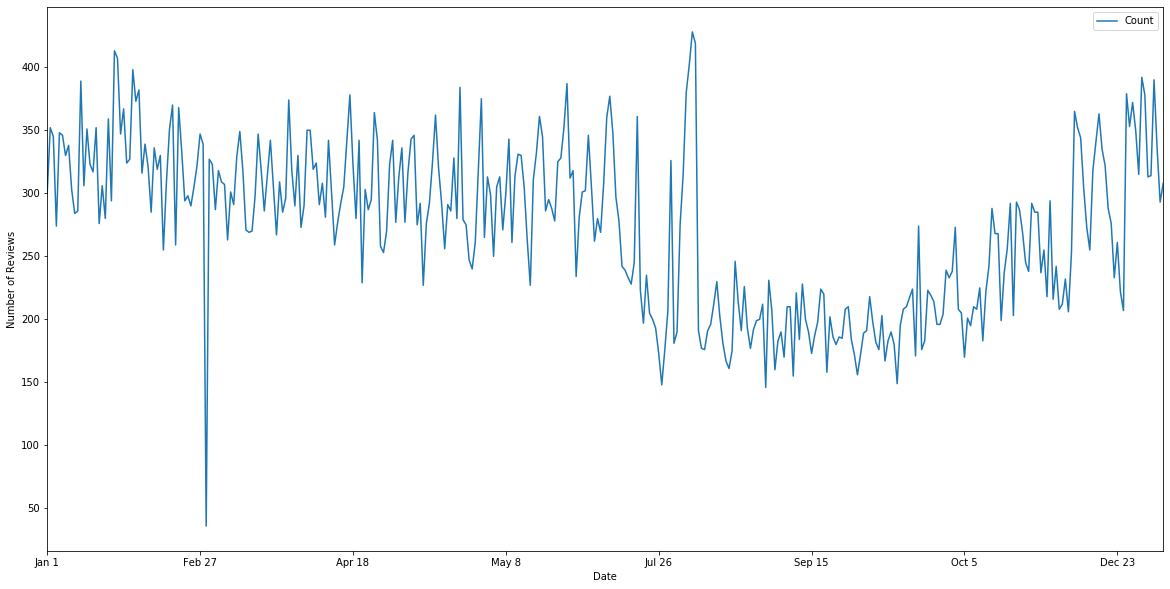

In [ ]:
ax = times_year.plot('Date', 'Count', figsize = (20,10))
ax.set_ylabel("Number of Reviews")

Just as suspected, there were about 1/6th of the reviews on that day than on the days around it, so the average review score would have been more affected by any reviews on either extremes, and it seems that there were quite a few reviews on the lower extreme that caused the average score to drop.

Another interesting observation from this graph is the reduction in the number of reviews over the course of late summer and fall. This could very likely be due to people saving up at that time of year for the holiday season, an explanation that is further credited by the fact that the review count rises again once we reach December.

Now instead of looking at the average score based on the day of the year, let's instead look at it on a year by year basis, to see if there are any trends over the period of time that the dataset covers. To help us analyse the graph we will also plot a line depicting the average review star rating across the entire dataset.

Text(0, 0.5, 'Average Star Rating')

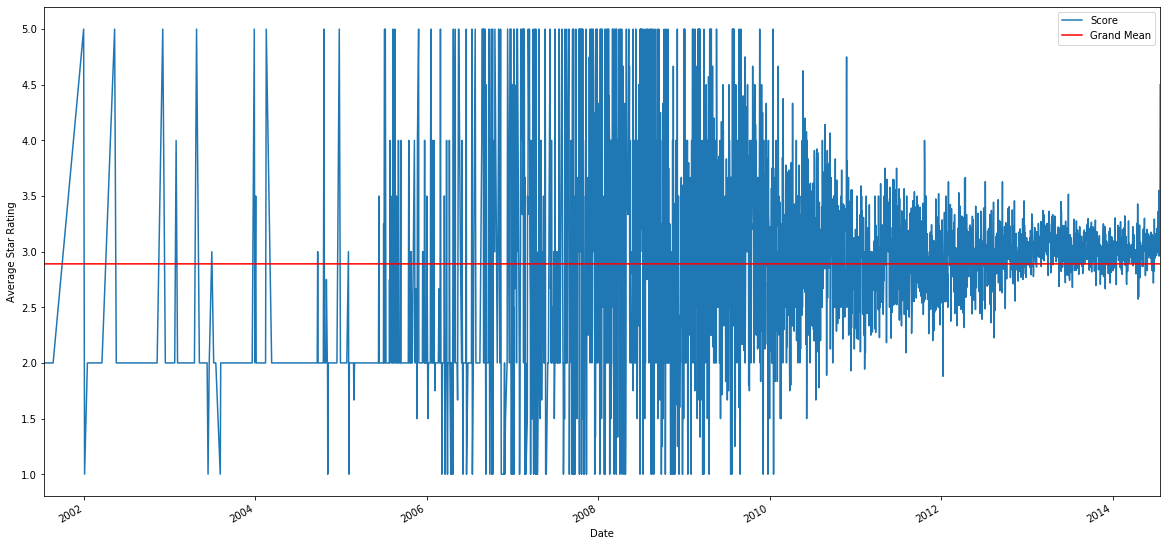

In [ ]:
y_value = times_date['Score'].mean()
times_date['Grand Mean'] = y_value
ax = times_date.plot('Date', 'Score', figsize = (20,10))
times_date.plot('Date', 'Grand Mean', color = 'red', ax = ax)
ax.set_ylabel("Average Star Rating")

While we notice that the average review score prior to 2006 is mostly on 2.0, with certain small periods of very high/low reviews causing the average to deviate, this is likely since Amazon grew significantly post 2006 ([Source](https://image.businessinsider.com/56abe654c08a80431d8bb4ef?width=700&format=jpeg&auto=webp)). What is interesting however is that post 2006 while changes in the mean appear to be a lot more frequent there are still a lot of extreme values, with the average score often hitting 1.0 and 5.0, which are the lowest/highest possible review scores respectively.

To explain this we need to once more see a corresponding graph across the same timeline that shows the number of reviews, as it is very unlikely that there would be days in our dataset to have a lot of reviews and have an average review score of 5.0 or 1.0, as it implies minimal (if any) reviews were posted on that day that were not either 1 or 5 stars. It is likely that around 2011/2012, where we see the variation from the grand mean is much smaller, that we have a much higher review count than times where the variation is larger.

Text(0, 0.5, 'Number of Reviews')

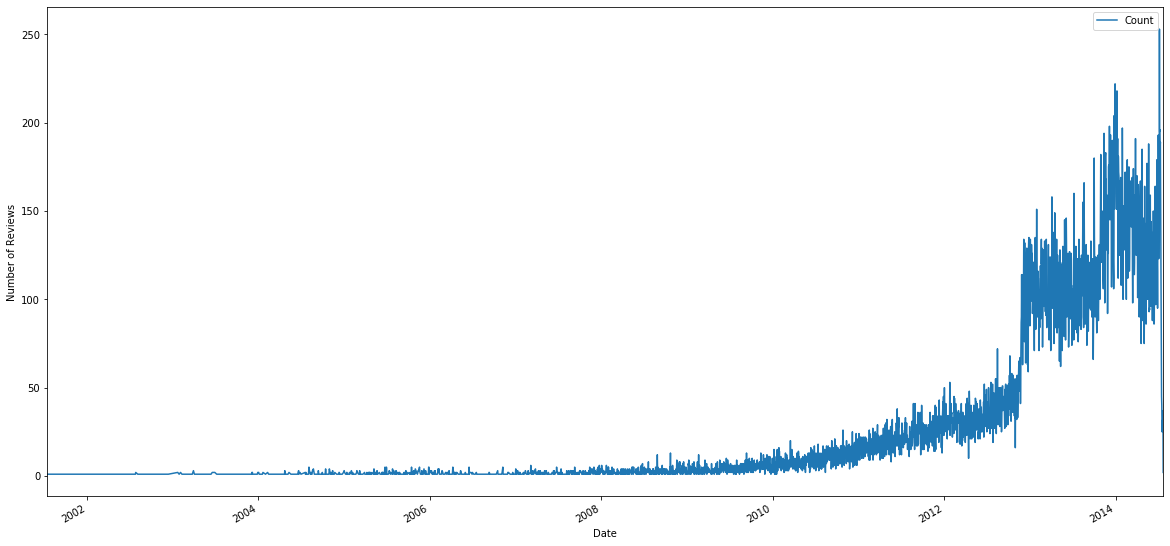

In [ ]:
ax = times_date.plot('Date', 'Count', figsize = (20,10))
ax.set_ylabel("Number of Reviews")

Once again the count graph explains the phenomenon we saw before. While we notice more variation in the count starting at around 2006 we do not see a large rise in the review count until around 2011/2012, which was around the same time that we saw the large decrease in variation from the grand mean.

We can even take this a step further, and plot the exact value of variation from the mean over each day as well as the count of reviews for that day to make it easier to directly compare the two.

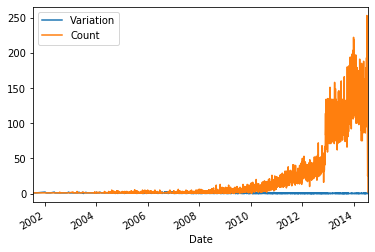

In [ ]:
times_date['Variation'] = times_date.Score.apply(lambda x: abs(x - 2.890193))
ax = times_date.plot("Date", "Variation")
times_date.plot("Date", "Count", ax = ax)

Oops, we can't see anything! The scales are far too different! Let's normalise the values and try again.

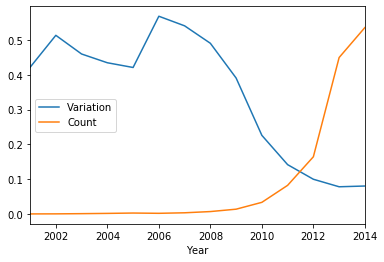

In [ ]:
# get a year column in the df
times_date['Year'] = times_date.Date.apply(lambda x: x.year)
# find the min and max of both columns
min_var, max_var = times_date['Variation'].min(), times_date['Variation'].max()
min_count, max_count = times_date['Count'].min(), times_date['Count'].max()
# normalize both columns
times_date['Variation'] = times_date['Variation'].apply(lambda x: (x-min_var)/(max_var-min_var))
times_date['Count'] = times_date['Count'].apply(lambda x: (x-min_count)/(max_count-min_count))
# groupby year and find the avg value of each column for each year
times_monthly = times_date.groupby('Year').mean().reset_index()[['Year', 'Count', 'Variation']]
ax = times_monthly.plot("Year", "Variation")
times_monthly.plot("Year", "Count", ax = ax)

Much better! Just as we expected, there is an inverse relationship between the variation and the count, and since variation starts to drop off just as count increases, while we cannot be certain we can say that it is quite likely that a higher count causes a lower variation.

## LDA Model


In this section we will investigate trying to see if the reviews in the dataset are centered around certain topics. We will use LDA topic modelling in order to try and determine how many topics there are in the data, as well as investigate the key words in each topic.



### Preparing The Model
First things first let us get the Tfidf score of each word of each review. Tfidf stands for term frequency inverse document frequency, and as the name suggests it gives words higher weights the more they appear in each document, but also lowers the weights based on how frequent they appear in the document collection as a whole. The goal of Tfidf is to give high weights to words that appear often in a certain document, and are not found commonly in other documents, meaning the word is more "unique" to the document, and not just a common word that is generally used a lot.

In [ ]:
reviews_tfidf = TfidfModel(reviews_bow)[reviews_bow]

In order to determine how many discernable topics there are in our data, we will run an LDA model on a number of different possible topics, and then observe the coherence score for that model. We will be using the UMass measure, which gives higher scores if two words in the same topic appear together in documents a lot relative to how often the individual words alone appear in documents.

Note that UMass is always negative, and the closer to 0 the score is, the better the topic model is.

In [ ]:
# testing from 2 to 14 topics
topics = np.arange(2,15,1)
coherences = []
for topic in topics:
  lda_model = LdaModel(reviews_tfidf, id2word=reviews_dict, num_topics=topic, \
                      passes = 10, random_state = 100)
  coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, \
                        corpus=reviews_tfidf, dictionary=reviews_dict, coherence = 'u_mass')
  coherence_lda = coherence_model_lda.get_coherence()
  # append the score to a list of scores
  coherences.append(coherence_lda)

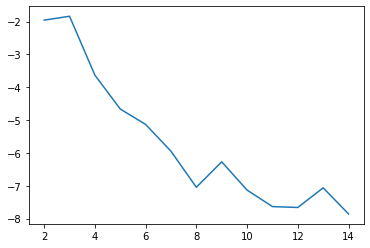

In [ ]:
plt.plot(topics, coherences)

From the graph it seems as though 3 topics gives us the best score, and while it is only marginally better than 2 topics, we can see that as we go above 3 the score drops very significantly.

We will now train a model on 3 topics (this time with more passes over the dataset), and try and analyse the results.

In [ ]:
model = LdaModel(reviews_tfidf, id2word=reviews_dict, num_topics=3, passes = 20, \
                 random_state = 727)

We can use the print_topics method of the model in order to get a list of the most influential words in teach topic, and their respective "magnitude of influence."

In [ ]:
topics = model.print_topics()
pprint(model.print_topics())

[(0,
  '0.008*"product" + 0.006*"take" + 0.006*"tast" + 0.005*"smell" + 0.005*"use" '
  '+ 0.005*"work" + 0.004*"help" + 0.004*"tri" + 0.004*"day" + 0.004*"pill"'),
 (1,
  '0.007*"size" + 0.006*"wear" + 0.006*"fit" + 0.005*"comfort" + 0.005*"great" '
  '+ 0.004*"like" + 0.004*"good" + 0.004*"well" + 0.004*"shoe" + 0.004*"love"'),
 (2,
  '0.005*"use" + 0.005*"razor" + 0.005*"shave" + 0.005*"batteri" + '
  '0.005*"work" + 0.004*"blade" + 0.004*"one" + 0.003*"good" + 0.003*"get" + '
  '0.003*"great"')]


From viewing the top 10 words for each topic, it seems as though the first topic that the model classified is a bit vague, although it mentions pills and taste/smell, so for now let us assume that it is to do with nutritional products, eg vitamins (we will investigate deeper shortly).

The second topic is much more clear at first look, it seems to be about shoes, and the reviews for the shoes seem quite positive!

Finally the last topic seems to cover electric razors, with the mention of "shave", "razor", and "batteri."

Although we are given the weightings of each word the numbers are very small, and therefore hard to visualize on a relative scale. Let's pick a topic (I chose topic 3), and use a Treemap to visualise the relative importance of each word.

### Visualization


[0.005, 0.005, 0.005, 0.005, 0.005, 0.004, 0.004, 0.003, 0.003, 0.003]


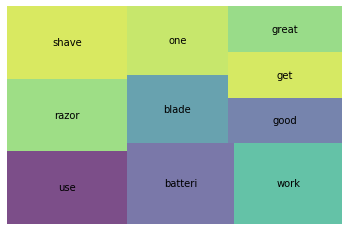

In [ ]:
# split the string of weights on the +
topic_list = topics[2][1].split(" + ")

sizes = []
labels = []
for i in topic_list:
  sizes.append(float(i.split('*')[0]))
  # split once more on the * and then remove the extra characters
  labels.append(i.split('*')[1].strip("\""))

print(sizes)
squarify.plot(sizes=sizes, label=labels, alpha=.7 )
plt.axis('off')
plt.show()

This is much more interpretable. As we can see, words such as "great" have less importance than the words we used to distinguish the topic, such as "shave" or "razor", however it is odd that "use" takes up a lot of space, since it does not seem to be a topic word but rather a general word used in reviews.

In order to investigate each topic slightly more deeply, we will make use of the pyLDAvis module, which creates a nice big visualization of the different topics in the LDA model, as well as the 30 top words, and their relative impact on the topic.

In [ ]:
# NOTE: if rerunning the notebook, this cell will take a while
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, reviews_tfidf, reviews_dict)
vis

/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.066750  0.114393       1        1  39.073517
1     -0.109301 -0.097335       2        1  35.915409
0      0.176051 -0.017058       3        1  25.011078, topic_info=     Category         Freq     Term        Total  loglift  logprob
918   Default   969.000000     wear   969.000000  30.0000  30.0000
1543  Default   665.000000     tast   665.000000  29.0000  29.0000
261   Default  1253.000000     size  1253.000000  28.0000  28.0000
1423  Default   951.000000  comfort   951.000000  27.0000  27.0000
362   Default   586.000000    smell   586.000000  26.0000  26.0000
...       ...          ...      ...          ...      ...      ...
57     Topic3   290.303284    clean   809.443787   0.3604  -5.9926
23     Topic3   301.021729     just  1383.745117  -0.1395  -5.9564
55     Topic3   299.903870     will  1314.495850  -0.0919  -5.9601
7      Topic3   294.757751   better  1026.470337   0.1381  -5.9774
167    Topic3   295.180298      get  1414.858765  -0.1813  -5.9760

[222 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
2327      1  0.992438  accur
2327      2  0.004616  accur
6683      2  0.997844   ankl
4354      2  0.995935   arch
2156      1  0.289815    bar
...     ...       ...    ...
3253      2  0.996521   wore
142       1  0.443045   work
142       2  0.270485   work
142       3  0.286365   work
1491      2  0.996232   worn

[372 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

This graph gives us much more information! We can see from the left hand side the 2D visualization of the three topics, and we can also observe that each topic is roughly the same size.

For the graph on the right, we can select each topic individually and the red bar for each of the key words in the topic tells us the frequency of that word within the topic, while the blue bar tells us the frequency of that word overall, giving us information that the treemap couldn't, in terms of seeing how often a topics frequent word may just be an overall frequent word and not unique to that topic itself. For example if the topic frequency of a term (red bar) is equal to the term frequency (blue bar), then it tells us that the term only appears within that topic and not in any others, which is the best indicator of a word that defines that topic.

Diving deeper into the key words for the first topic we can see that it is shaving products as expected, and although "use" was the most important word in the topic, we can see from the light blue bar that accompanies the red bar that it was a frequent term in every topic, not just this one. "razor", "shave", and "batteri" however are either mostly or completely localized within this topic, showing that they are better words to define the topic than "use", even though "use" has a higher frequency within the topic.

For the second topic we can definitely tell that it is about shoes, as words such as "shoe", "wear" and "feet" all have topic freuencies that are either equal to or very close to the overall freuency, suggesting that they are not mentioned outside of this topic.

Lastly we are now able to get more of an indication of what the third topic is about, as words such as "vitamin" and "supplement" which have topic frequencies equal to the overall frequency give us an indication that this topic is centered around medicine/supplements. Notice how the word "use" is once more one of the top words of this topic. If we had only printed the key words for a topic/used the treemap, then we would have thought that "use" was a key word for the topic, however this form of visualization tells us that is not the case, showing some of the shortcomings of the treemap in this scenario.

## Building a Classifier

Now, after thoroughly investigating the data, it is time to try and model/predict the star ratings for individual reviews.

### Getting Data in The Desired Format

Gensim stores the documents in a Count Bag of Words format, meaning that within a document, each word has its ID as well as an associated "count" of how many times it appears in that document. After the previous investigation and seeing how words such as "use" appear in a large portion of reviews, it could be the case that these words skew our models predictions.

To combat this we will switch to a Binary Bag of Words format, meaning that for each word in the document, instead of associating that word with its count, we just use a "1" to indicate that the word is present in the document.

Firstly we must get the words out of the CBoW format into plaintext, which we can use the provided dictionary to do.

In [ ]:
docs = []
# iterate through list of docs
for review in reviews_bow:
  lst = []
  for i in review:
    for j in range(int(i[1])):
      # append each word the number of times it appears
      lst.append(reviews_dict[i[0]])
  docs.append(" ".join(lst))

Let's have a look at one of the reviews to make sure it is in the format that we want it in.

In [ ]:
print(docs[110])

play toy now around like like thing even cat interest throw zero toss fun bat collect couch dangl dust somewher watch


Now we must create a vocabulary. In order to ensure that each word we include in our vocabulary is a "notable" word, and is a word that can be used to generalize reviews as a whole, we will only store words that appear more than once across the set of reviews. All words that occur only once will be collectively mapped to an "\<unk>" token.


In [ ]:
voc_dict = {}
for doc in docs:
    # split the doc into words
    for token in doc.split():
        # voc_dict counts how many times each word appears across the list of docs
        # we can use this to make sure we don't count words that only appear once overall
        if token in voc_dict:
            voc_dict[token] += 1
        else:
            voc_dict[token] = 1

vocab = ['<unk>']
# for each word in the dictionary, append it to the vocab if it has appeared more than once
for word in voc_dict:
    if voc_dict[word] > 1:
        vocab.append(word)

The function below converts each document to our desired featurization. So each document will be represented by a dictionary, where the keys of the dictionary are all the words in our vocabulary that appear in the document. If there are any words in the document that are not in our vocabulary, then there will also be an '\<unk>' key. 

(Note: We use a dictionary here since we need a sparse representation, as a dense representation in this case would take up far too much space and be very computationally inefficient, since our vocab is approximately 17000 words, and in dense form our data would be a 2D array of size 100000x17000, which is far too large) 

In [ ]:
def convert_document_to_feature_dictionary(doc, vocab):
    bow_dict = {}
    for token in doc.split():
        # check if the word exists in the vocab
        if token in vocab:
            bow_dict[token] = 1
        else:
            bow_dict['<unk>'] = 1
    
    return bow_dict

In [ ]:
vectorized_docs = []
for doc in docs:
  # vectorize each doc
  vectorized_docs.append(convert_document_to_feature_dictionary(doc,vocab))

### Running The Model

In order to run sklearn functions with a dictionary as input we must first convert them into scipy sparse matrices, which we will use sklearns DictVectorizer to do.

In [ ]:
v = DictVectorizer()
X = v.fit_transform(vectorized_docs)
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size = 0.2, random_state = 997)

We will run two different linear models on the data. Since our data has no extreme values, models such as gradient descent or logistic regression will likely work well.

In [ ]:
lr = linear_model.LogisticRegression(max_iter = 500)
lr.fit(X_train, y_train)
print(f"LR Acc: {lr.score(X_test, y_test)}")

sgd = linear_model.SGDClassifier(random_state=1997).fit(X_train, y_train)
print(f"SGD Acc: {sgd.score(X_test, y_test)}")


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LR Acc: 0.87555
SGD Acc: 0.87295


We manage to get an 87.6% accuracy for Logistic Regression and a 87.3% for SGD! These results are very promising, and indicate that our assumption that a Binary Bag of Words may result in less noise for the models are likely to be accurate assumptions.